# Example of usage Spark OCR for de-identify Dicom documents using NLP pipeline and DicomDeidentifier

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-ac750be386cb)

In [ ]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

In [ ]:
# NBVAL_SKIP
# install from PYPI using secret
%pip install --upgrade spark-nlp-jsl==4.4.0  --extra-index-url https://pypi.johnsnowlabs.com/$nlp_secret
%pip install spark-nlp==4.4.0
%pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
%pip install pydicom highdicom
%pip install pillow-jpls
%pip install fuzzywuzzy

In [ ]:
# %pip install ../../../python/dist/spark-ocr-5.0.3rc1.tar.gz

## Initialization of spark session

In [ ]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              nlp_internal="5.3.0",
              jar_path=spark_ocr_jar_path)

spark

Spark version: 3.2.1
Spark NLP version: 5.1.2
Spark NLP for Healthcare version: 4.4.0
Spark OCR version: 5.1.2rc3



## Import Spark OCR transformers and Spark NLP annotators

In [ ]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

import pillow-jpls

## Define de-identification  NLP pipeline

In [ ]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = DocumentNormalizer() \
      .setInputCols(prefix + "document_raw") \
      .setOutputCol(prefix + "document") \
      .setAction("clean") \
      .setPatterns(cleanUpPatterns) \
      .setReplacement(" ") \
      .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'ID','DOCTOR'])

    chunk_merge = ChunkMergeApproach()\
        .setInputCols("entity","ner_chunk")\
        .setOutputCol("deid_merged_chunk")

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            documentNormalizer,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter,
            chunk_merge
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [ ]:
from pyspark.ml import PipelineModel, Pipeline

dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.7)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

deidentifier = DicomDeidentifier() \
    .setInputCols(["positions", "metadata"]) \
    .setOutputCol("entity") \
    .setKeepInput(True) \
    .setBlackList(["acc"])

position_finder = PositionFinder() \
    .setInputCols(["deid_merged_chunk"]) \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setIgnoreSchema(True) \
    .setOcrScaleFactor(1.0)

# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setAggCols(["path", "content"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_metadata,
    dicom_to_image,
    text_detector,
    ocr,
    deidentifier,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_sd"),# model="ner_deid_generic_augmented"),
    position_finder,
    draw_regions, # comment last two stages for debug
    dicom_deidentifier
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_sd download started this may take some time.
[OK!]


## Read dicom objects as binary file and display metadata

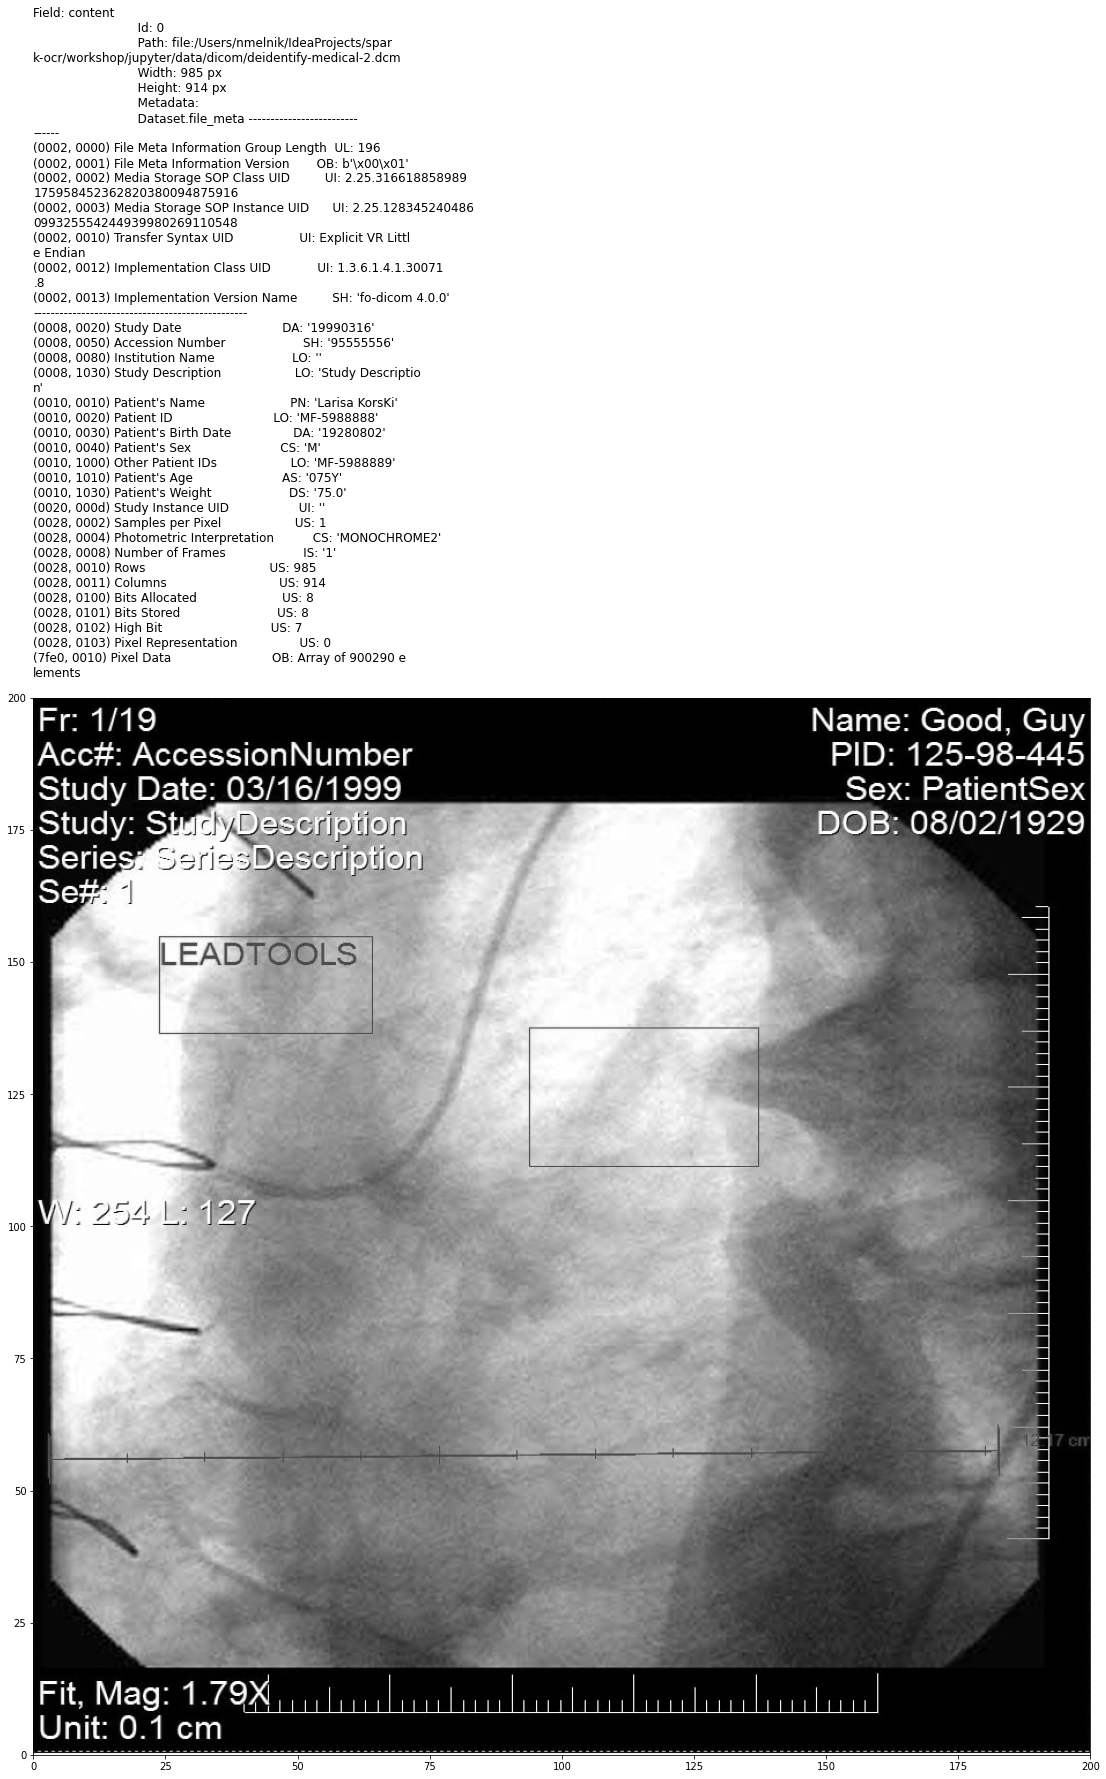

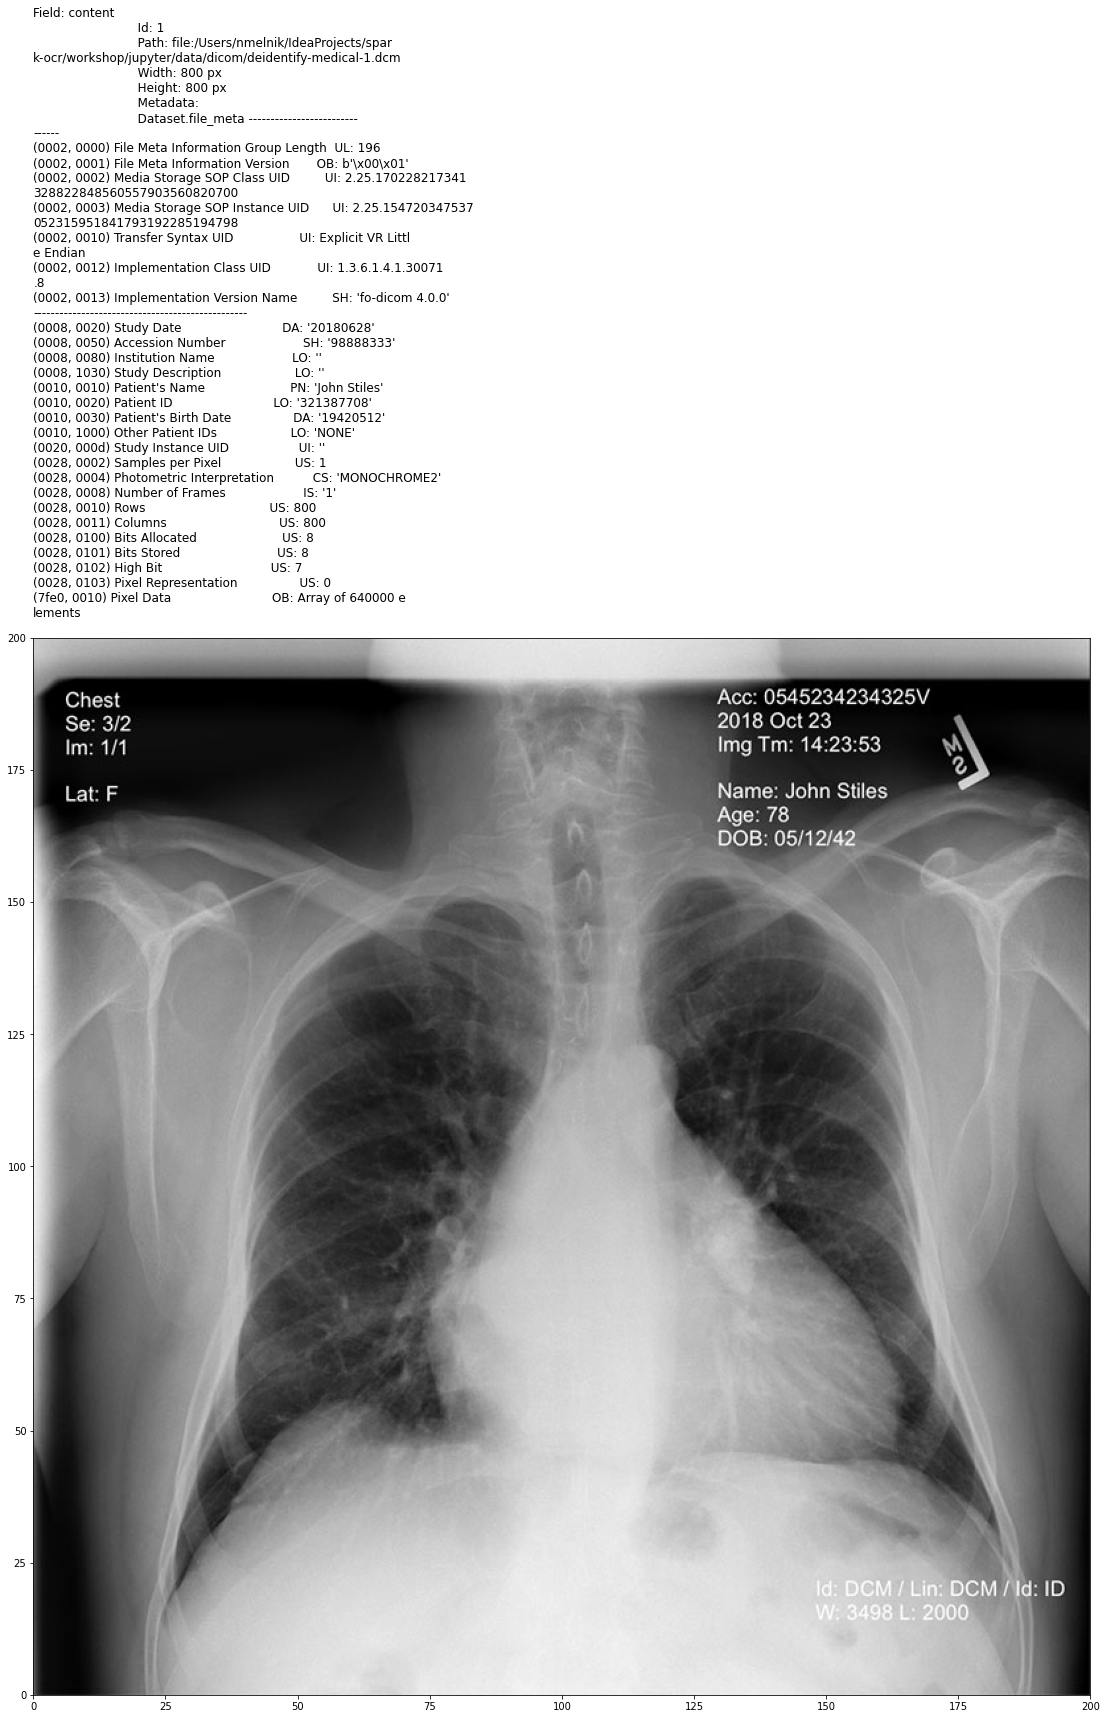

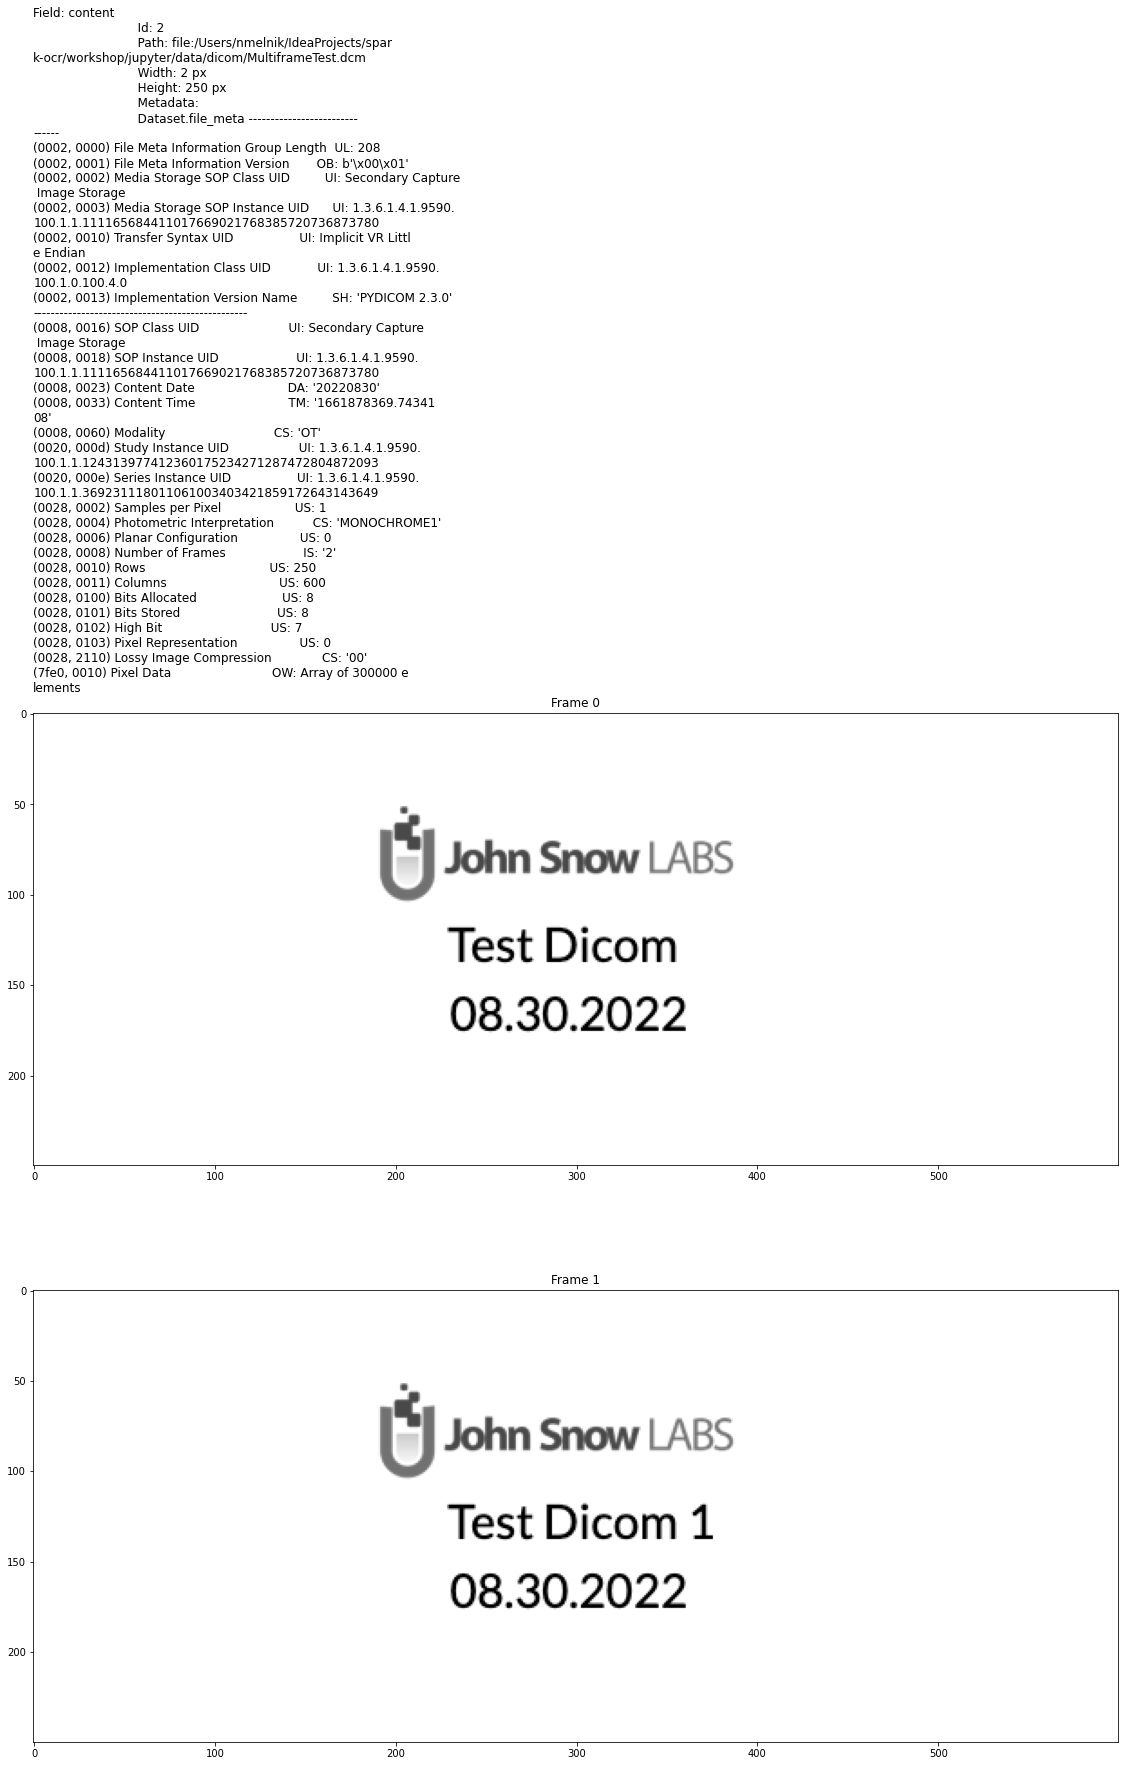

In [ ]:
dicom_path = './../data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path)#.limit(1)

display_dicom(dicom_df)

# Call pipeline

In [ ]:
result = pipeline.transform(dicom_df).cache()

## Show intermediate results for debug

#### <span style="color:red">Note:</span> Need to comment last two steps in the pipeline for run this cell !!!

In [ ]:
# NBVAL_SKIP
import pandas as pd
pd.set_option('display.max_colwidth', 500)
result.select("text", "positions", "entity", "ner_chunk",
              "deid_merged_chunk", "coordinates", "exception").toPandas()

text  \
0  Fr:\n1/19\nName:\nGood\nGuy\nAcc#:\nAccessionNumber\nPID:\n125-98-445\nStudy\nDate: 03/16/1999\nSex:\nPatientSex\nStudy: StwiWescnpuor\nDOB:.08/02/1929\nSeries#\nSerissMeserotor\nSet”\nLEADTOOLS\nWN: B54,\n127\n7\nFit.\nMag:\n1.79X\nUnit:\n0.1\ncm\n   
1                                                                                          Chest\nAcc: 0545234234325V\nSe\n3/2\n2018 Oct 23\nIm: 1/1\nImg Tm: 14:23:53\nv\nLat: F\nName: John Stiles\nAge\n78\nDOB: 05/12/42\nDCM /id: ID\nW: 3498 L: 2000\n   
2                                                                                                                                                                                                                y\nJohn Snow LABS\nTest Dicom\n08.30.2022\n   
3                                                                                                                                                                                                             y\nJohn Snow LABS\nTest Dicom\n1\n08.30.2022\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             positions  \
0  [([Row(c='Fr:', x=3.0, y=5.0, width=40.0, height=30.0, fontSize=0, source=''), Row(c='1/19', x=47.0, y=5.0, width=64.0, height=30.0, fontSize=0, source=''), Row(c='Name:', x=670.0, y=5.0, width=90.0, height=30.0, fontSize=0, source=''), Row(c='Good', x=765.0, y=5.0, width=77.0, height=30.0, fontSize=0, source=''), Row(c='Guy', x=853.0, y=7.0, width=60.0, height=30.0, fontSize=0, source=''), Row(c='Acc#:', x=3.0, y=38.0, width=71.0, height=30.0, fontSize=0, source=''), Row(c='AccessionNumber'...   
1  [([Row(c='Chest', x=22.0, y=37.0, width=47.0, height=19.0, fontSize=0, source=''), Row(c='Acc: 0545234234325V', x=515.0, y=34.0, width=166.0, height=19.0, fontSize=0, source=''), Row(c='Se', x=21.0, y=56.0, width=24.0, height=19.0, fontSize=0, source=''), Row(c='3/2', x=50.0, y=56.0, width=27.0, height=17.0, fontSize=0, source=''), Row(c='2018 Oct 23', x=515.0, y=53.0, width=92.0, height=19.0, fontSize=0, source=''), Row(c='Im: 1/1', x=20.0, y=73.0, width=54.0, height=19.0, fontSize=0, sourc...   
2                                                                                                                                                        [([Row(c='y', x=190.0, y=53.0, width=34.0, height=50.0, fontSize=0, source=''), Row(c='John Snow LABS', x=224.0, y=67.0, width=166.0, height=24.0, fontSize=0, source=''), Row(c='Test Dicom', x=227.0, y=115.0, width=131.0, height=27.0, fontSize=0, source=''), Row(c='08.30.2022', x=228.0, y=153.0, width=137.0, height=27.0, fontSize=0, source='')],)]   
3                                                                          [([Row(c='y', x=190.0, y=53.0, width=34.0, height=50.0, fontSize=0, source=''), Row(c='John Snow LABS', x=224.0, y=67.0, width=166.0, height=24.0, fontSize=0, source=''), Row(c='Test Dicom', x=227.0, y=115.0, width=131.0, height=27.0, fontSize=0, source=''), Row(c='1', x=362.0, y=117.0, width=17.0, height=23.0, fontSize=0, source=''), Row(c='08.30.2022', x=228.0, y=153.0, width=137.0, height=27.0, fontSize=0, source='')],)]   

                                                                                                                                                                                      entity  \
0                                                                                                   [(named_entity, 24, 29, Acc#:, {}, []), (named_entity, 30, 45, AccessionNumber, {}, [])]   
1  [(named_entity, 0, 5, Chest, {}, []), (named_enti

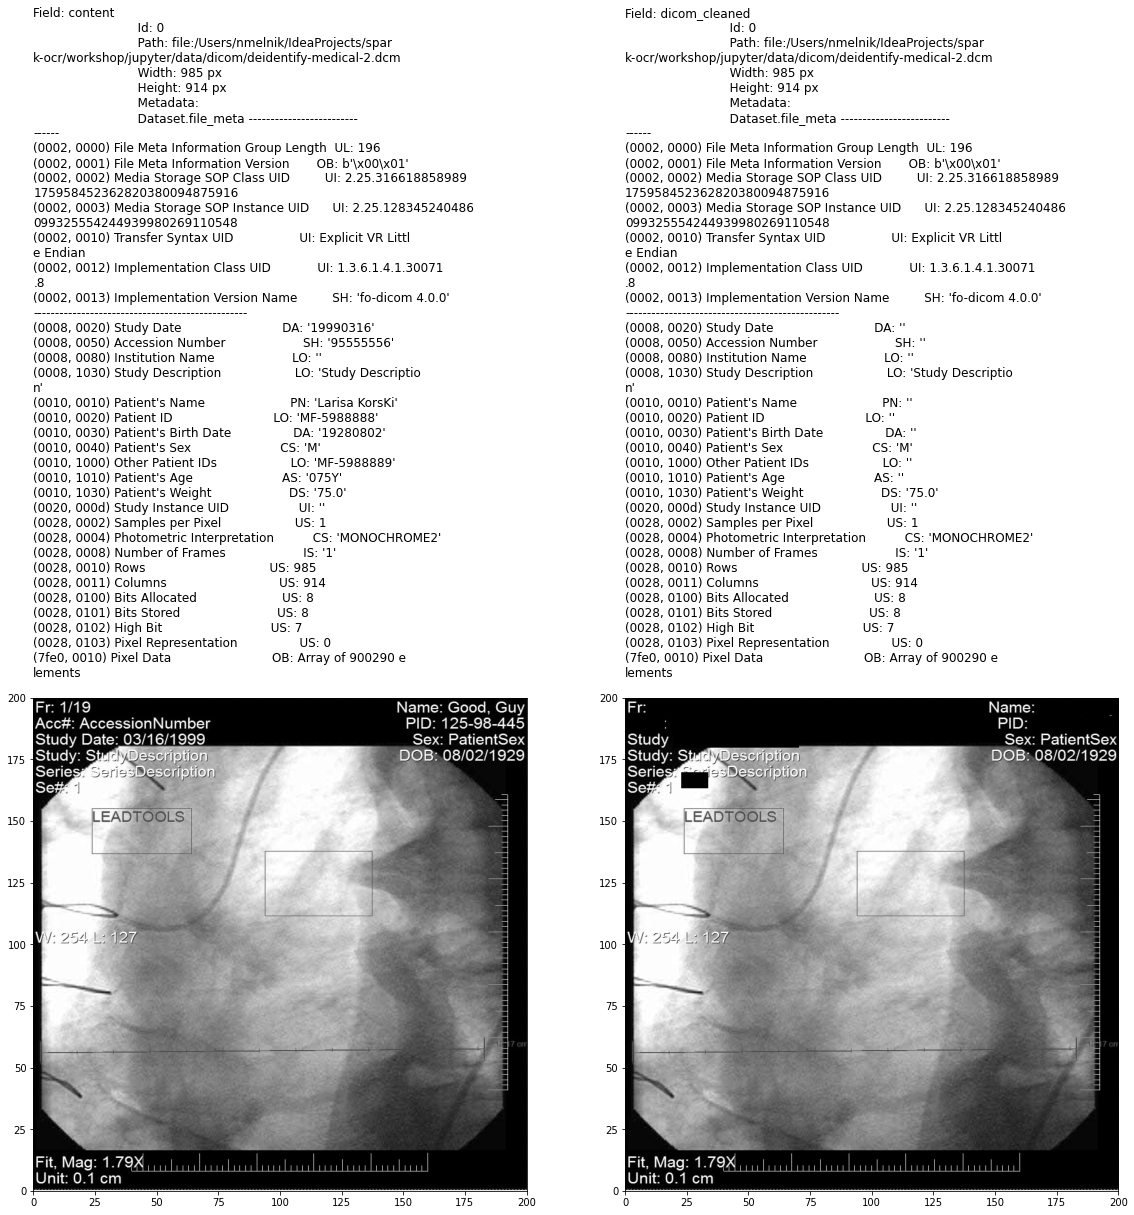

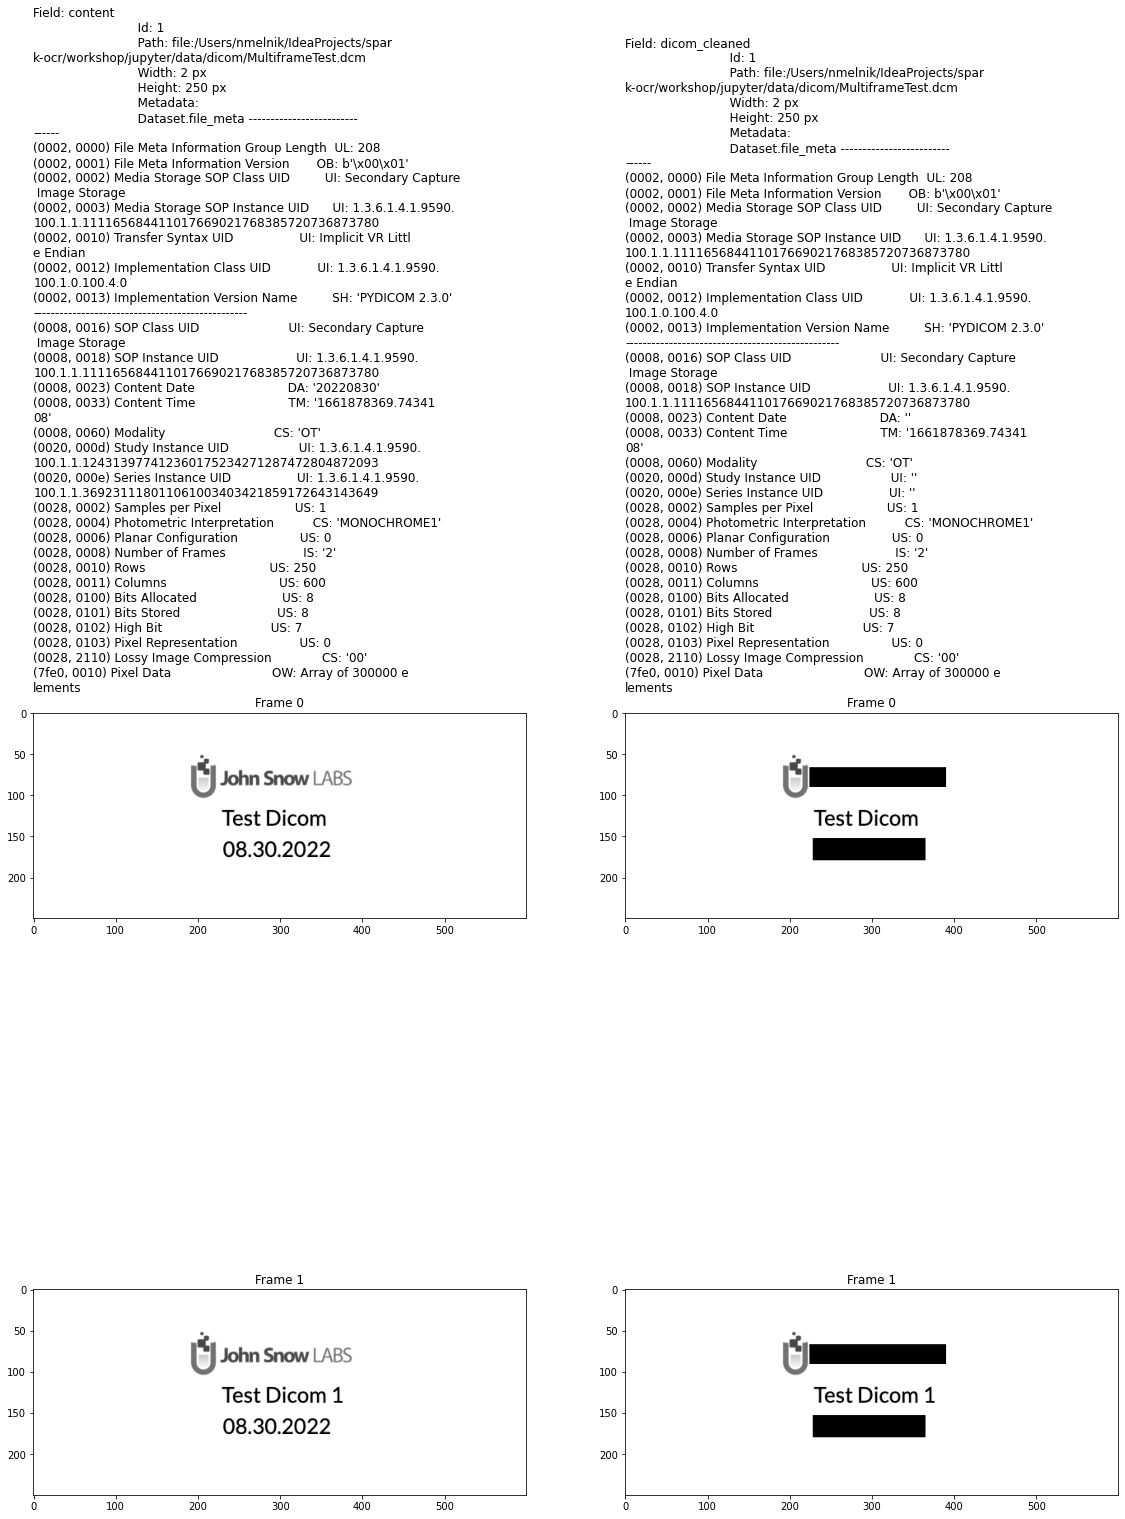

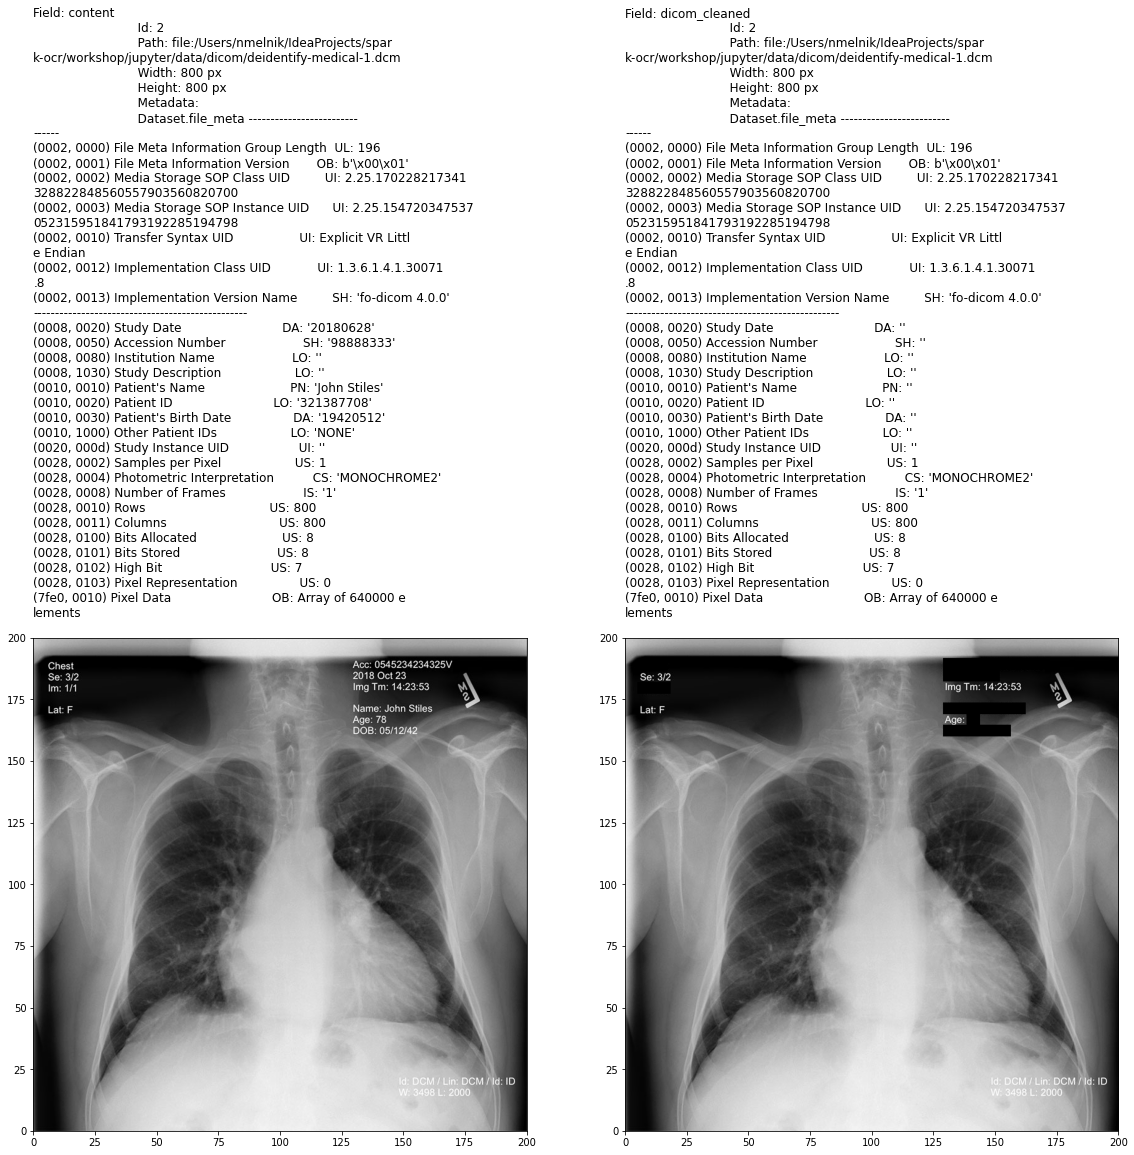

In [ ]:
display_dicom(result, "content, dicom_cleaned")

In [ ]:
# NBVAL_SKIP
output_path = "./../data/dicom/deidentified/"
from pyspark.sql.functions import *

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = path[-1].split('.')[0]
    return "/".join(path[-keep_subfolder_level-1:])

result.withColumn("fileName", udf(get_name, StringType())(col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "dicom") \
    .option("field", "dicom_cleaned") \
    .option("prefix", "ocr_") \
    .option("nameField", "fileName") \
    .mode("overwrite") \
    .save(output_path)

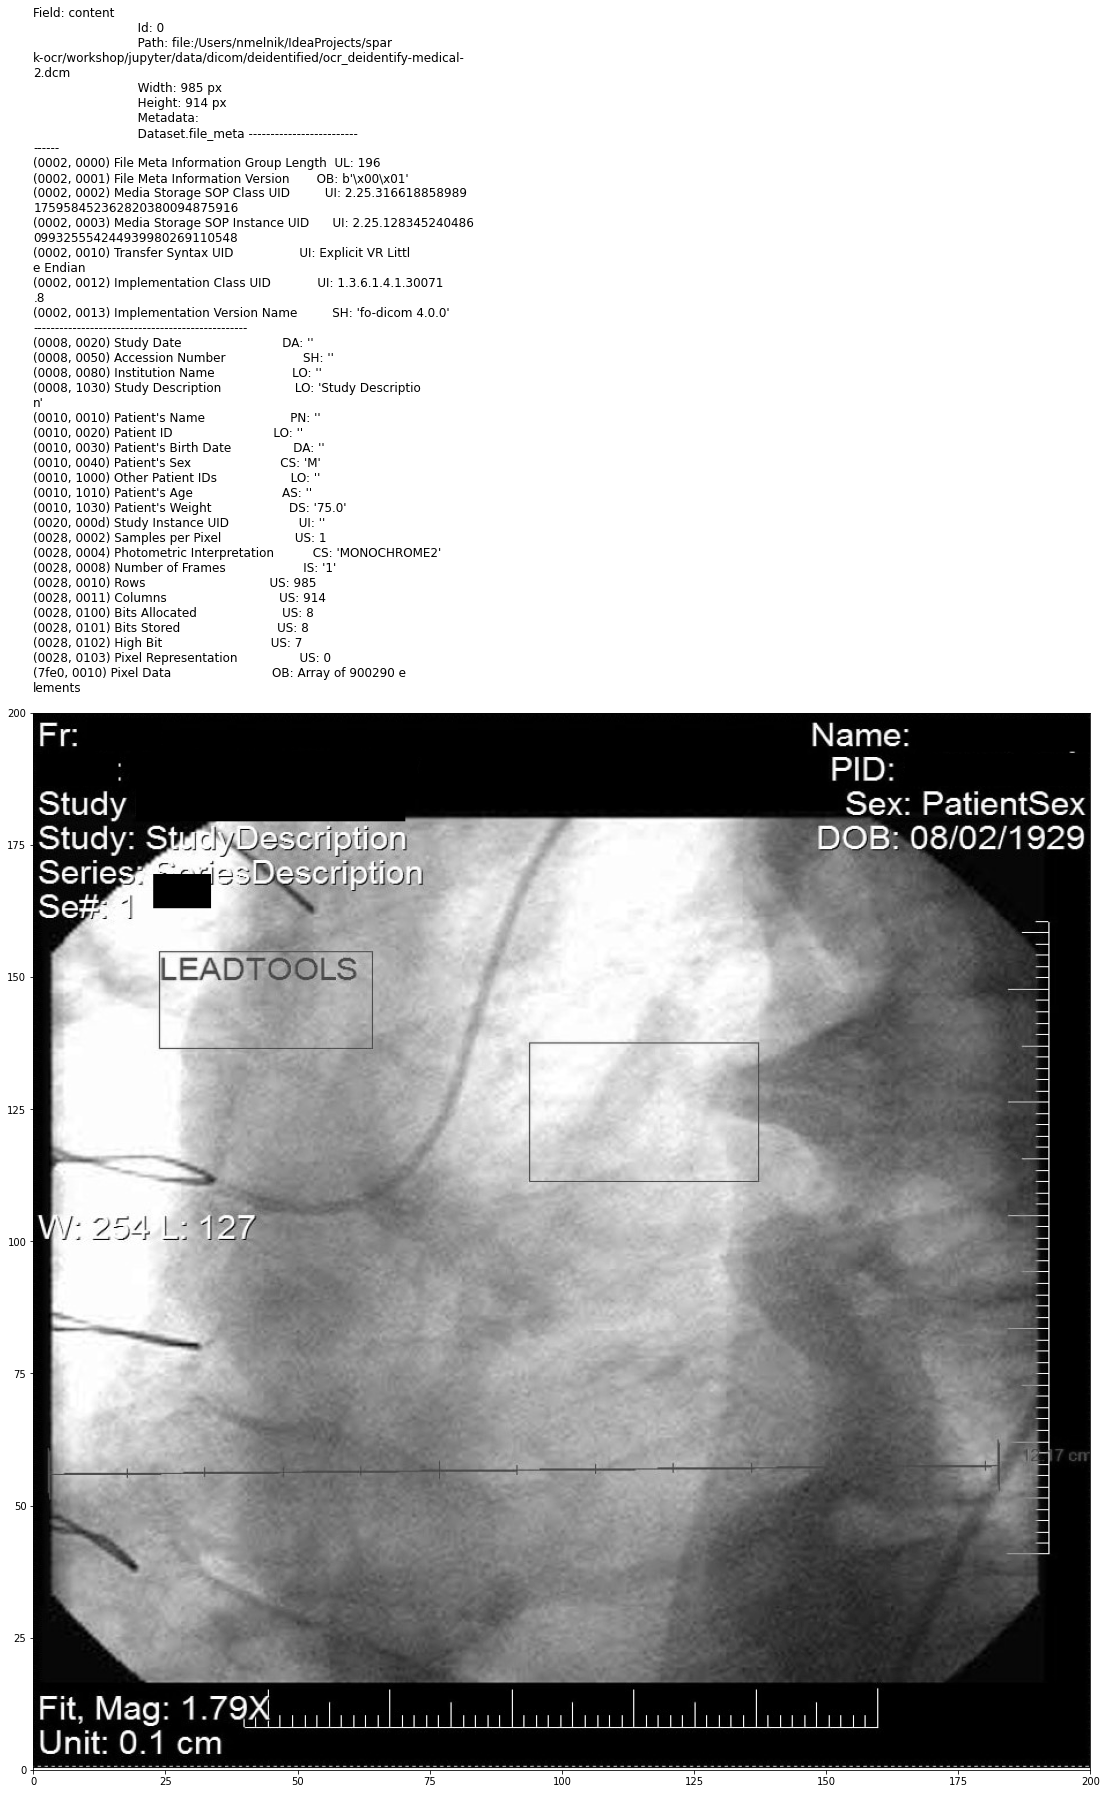

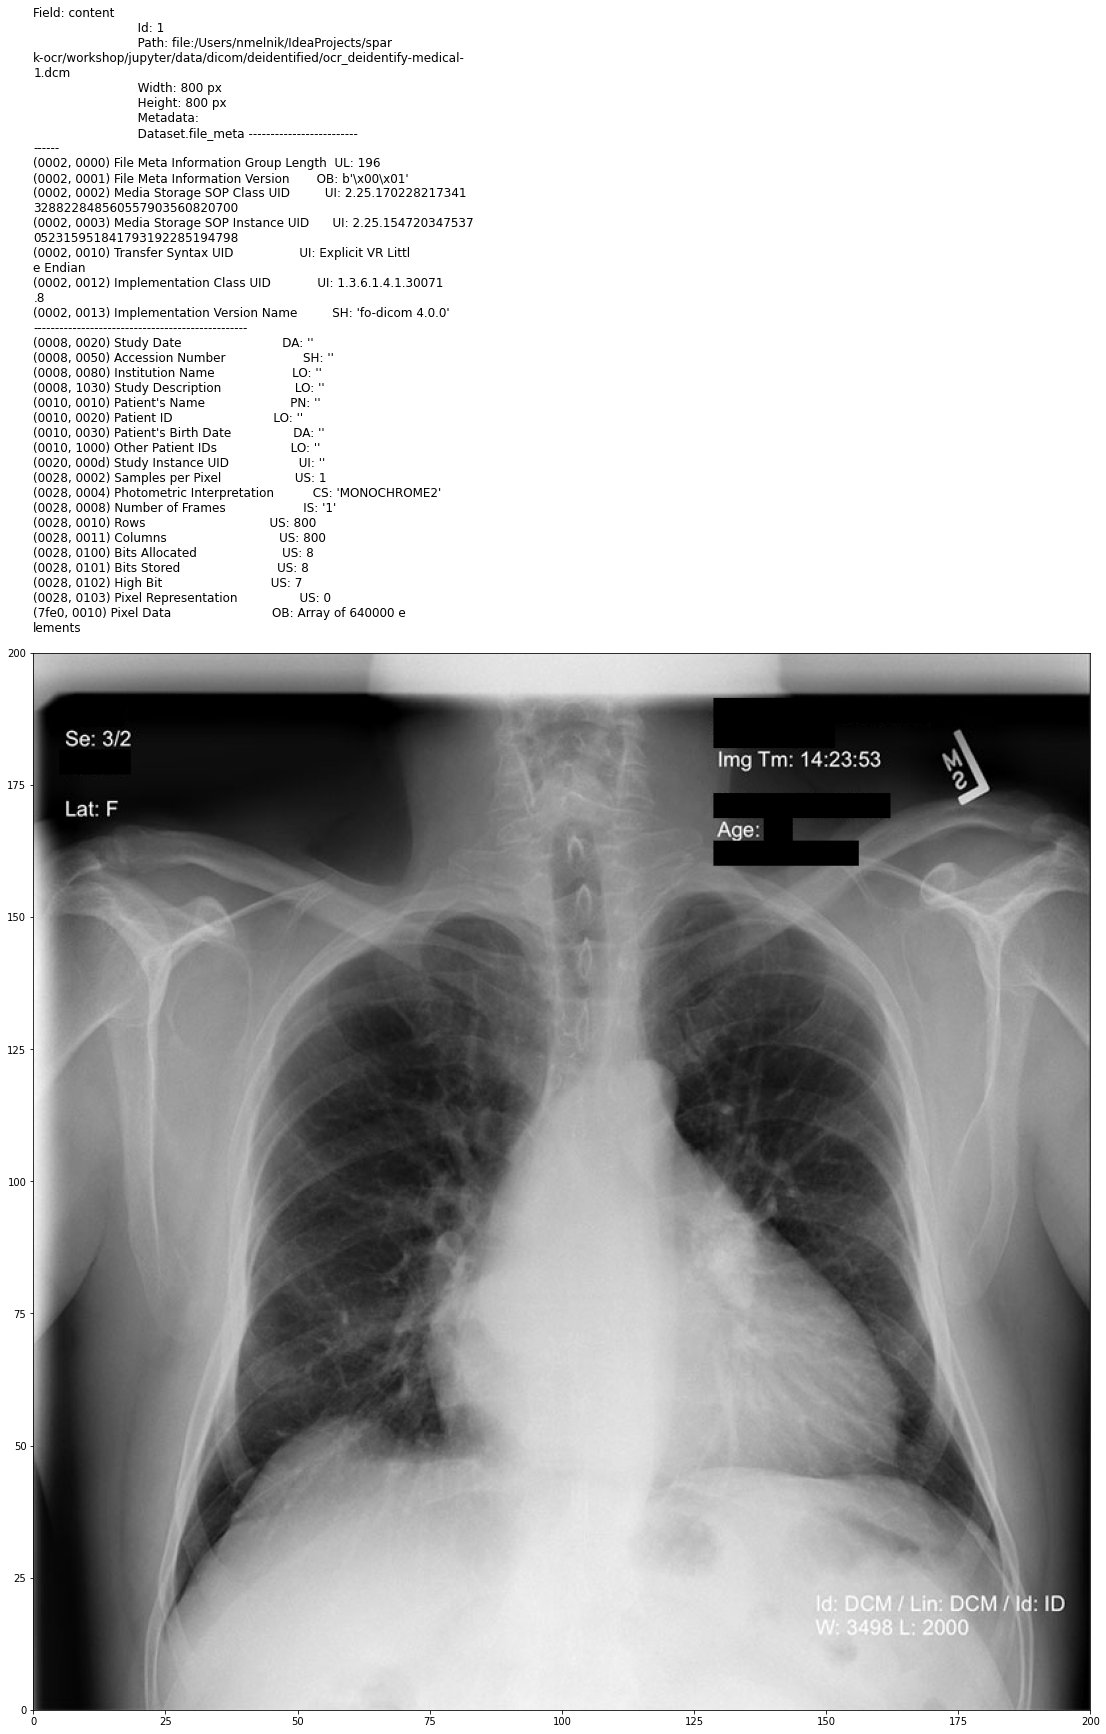

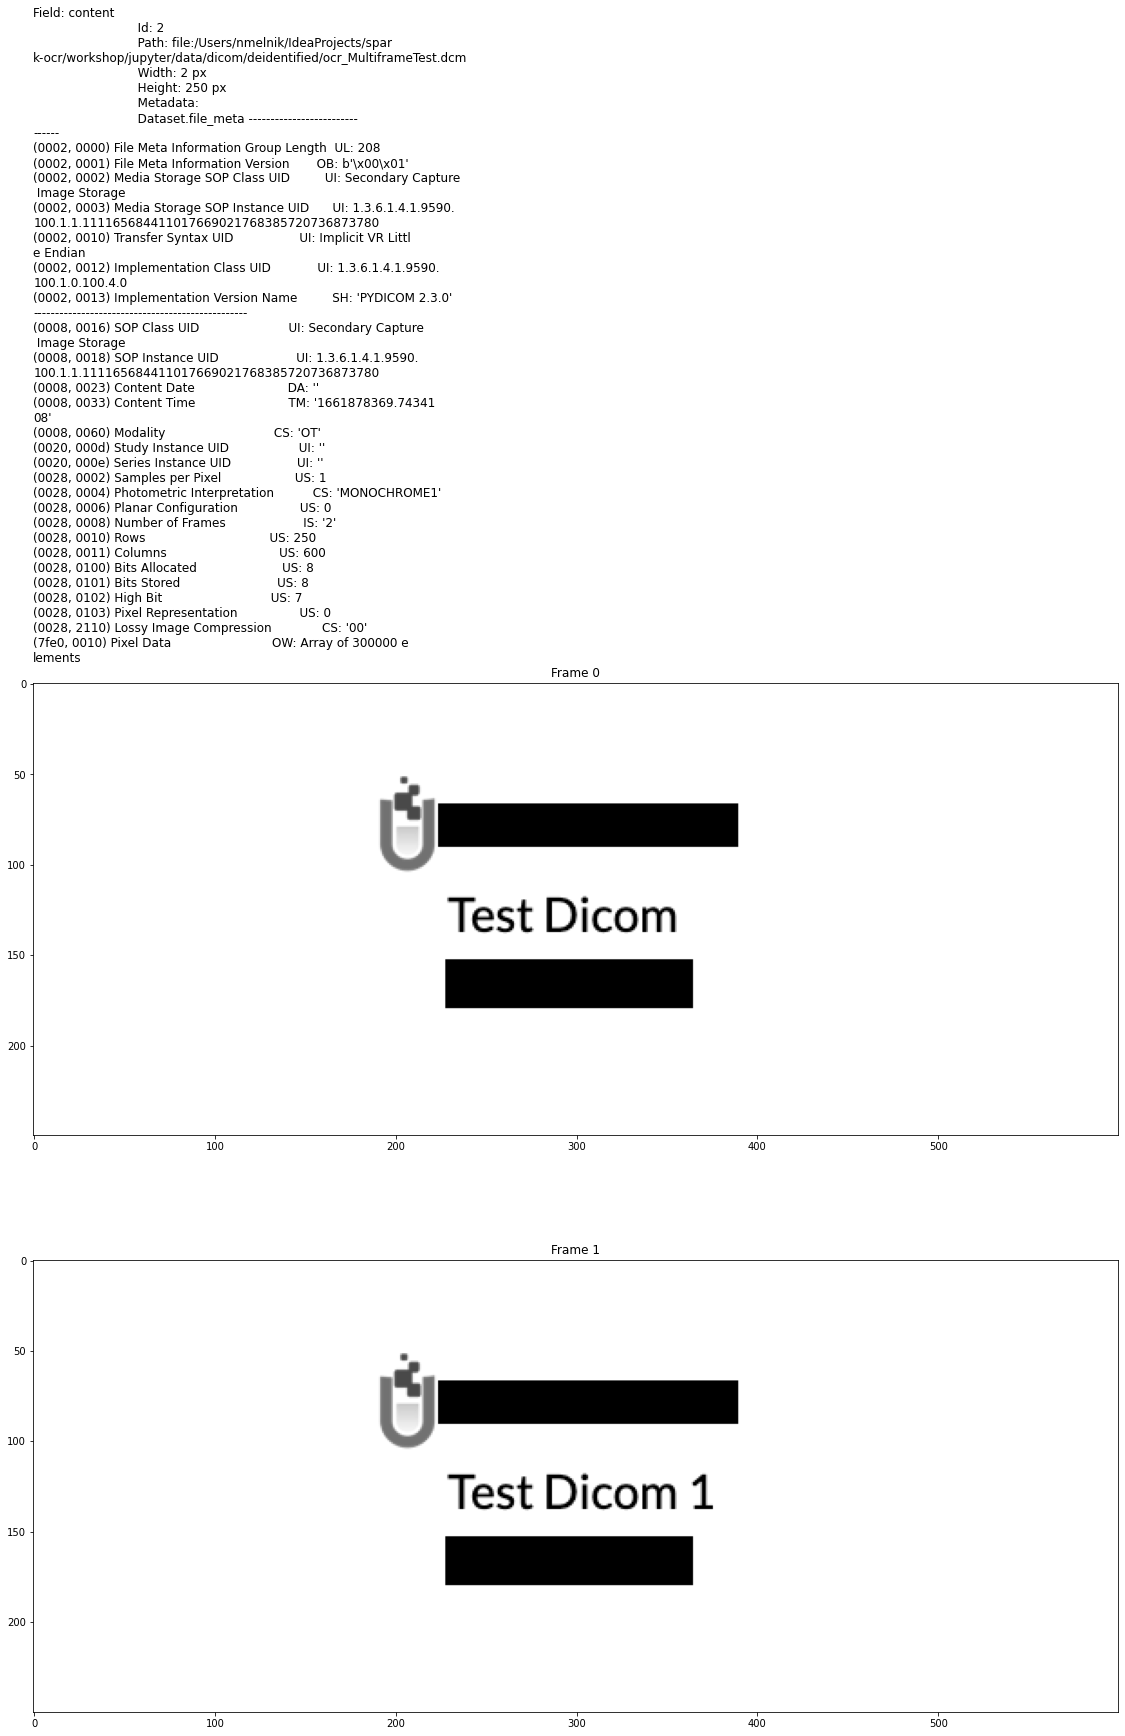

In [ ]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("./../data/dicom/deidentified/*.dcm")

display_dicom(dicom_gen_df)

In [ ]:
%%bash
rm -r -f ./../data/dicom/deidentified